In [1]:
import numpy as np
from datetime import datetime, timedelta
import math

In [ ]:
# Đủ dữ liệu--------------------------------------------------------------------------------
V = ["Tau1", "Tau2", "Tau3", "Tau4", "Tau5", "Tau6"] #Vessel
B = ["Berth1", "Berth2", "Berth3", "Berth4"] #Berth
VLi = [100, 200, 200, 250, 400, 400] #VLi (Chiều dài tàu i) (mét)
Uiu = False #1 nếu tàu i đi vào kênh ở vị trí u_th khi thủy triều dâng else 0
Viu = False #1 nếu tàu i đi ra khỏi kênh ở phía u_th khi thủy triều dâng else 0
E1 = 2.65 #Hệ số phát thải carbon của xe tải
n_ = 2.14 #Mức tiêu thụ nhiên liệu khi chạy không tải
#pl Mức tiêu thụ nhiên liệu của xe tải khi không tải được xác định bởi tốc độ và tải trọng
#pk Mức tiêu thụ nhiên liệu của xe tải khi đầy tải được xác định bởi tốc độ và tải trọng
E2 = 8.959 #Hệ số chuyển đổi điện năng sang khí thải carbon
lambda1 = 120 #Mức tiêu thụ năng lượng khi cần cẩu làm việc
lambda2 = 12 #Mức tiêu thụ năng lượng khi cần cẩu di chuyển giữa các vị trí
w1 = 0.4 #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w2 = 0.3 #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
w3 = 0.3 #trọng số có thể thay đổi tùy theo mục tiêu ưu tiên
e = 2.71828 #Hằng số logarit
TG0 = float(10)/60 #Thời gian cố định để tàu di chuyển qua kênh
TW0 = 24 #Thời gian chờ tối đa của tàu
VE = [100, 250, 250, 500, 1000, 1000] #Số lượng container tàu chở
CE0 = 120 # Hiệu suất làm việc thực tế của cần cẩu 
W = 6 #Độ dài mỗi khung thời gian thủy triều cao/thấp
R = 99999 #Một số nguyên đủ lớn để ràng buộc
M = 45 #Tổng số xe tải có thể sử dụng
CF0 = 2 #Năng suất lý thuyết cần cẩu trong bãi
vh = np.random.normal(loc=25, scale=4) #Tốc độ xe tải khi không tải
vl = np.random.normal(loc=18, scale=3) #Tốc độ khi xe container quá tải
VDi = [5 ,8, 8, 15, 30, 30] #VDi (Mớn nước của tàu i) (mét)
VCmi = [1, 1, 1, 1, 1, 1] #VCmi (Số cần cẩu tối thiểu cho tàu i ) (chiếc)
VCMi = [3, 3, 3, 4, 5, 5] #VCMi (Số cần cẩu tối đa cho tàu i) (chiếc)
Dij = [[1831, 2290, 2574, 3031],
       [2499, 1934, 2139, 2566],
       [2499, 1934, 2139, 2566],
       [3114, 2535, 2054, 2922],
       [3157, 2861, 2273, 2015],
       [3157, 2861, 2273, 2015]] #Dij: Khoảng cách từ tàu i (tại bến j) đến bãi đích, đơn vị km       
BLj = [400, 400, 300, 300] #BLj (Chiều dài của bến j ) (mét)
BDj = [20, 20, 15 ,15] #BDj (Mớn nước tại bến j ) (mét)

In [3]:
#Thiếu dữ liệu-------------------------------------------------------------------
VmL = [] #nhóm tàu lớn đang cập cảng
CKnt = [] #tập hợp số lượng xe tải phục vụ cẩu tại bến n thời điểm t 

In [4]:
# Dữ liệu tùy chọn---------------------------------------------------------------
xijk = [] #1 nếu tàu i phục vụ theo trình tự k tại bến j else 0
qitn = [] #1 nếu cần cẩu cầu cảng n phục vụ cho tàu i trong thời gian t else 0
u_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể vào
v_iu = [] # Biến nhị phân biểu thị khung thời gian tàu có thể ra
TH = [float(300)/vh, float(350)/vh, float(450)/vh, float(500)/vh] #Thời gian xe tải rỗng ddi  300 350 450 500
TL = [float(300)/vl, float(350)/vl, float(450)/vl, float(500)/vl] #Thời gian vận chuyển hàng hóa nặng bằng xe tải
VCit = [3, 3, 3, 4, 5, 5] #Số lượng cần cẩu phục vụ
T = [i for i in range(1,25)]
Tt = ["3:00 - 6:00", "15:00 - 18:00"] #Khung thoi gian thuy trieu cao
C = [i for i in range(1, 24)] #Crane
Y = [i for i in range(1, 46)] #Truck
l1 = np.random.normal(loc=15.75, scale=1.25) #Tải trọng của xe khi không tải 
l2 = np.random.normal(loc=33.5, scale=1.5) #Tải trọng của xe khi đầy tải 
TOi = ["30/12/2018 18:00:00", "31/12/2018 22:00:00", "02/01/2019 04:00:00", "02/01/2019 23:00:00", "03/01/2019 20:30:00", "04/01/2019 07:00:00"]  # Thời gian dự kiến tàu đến
x = [0.8, 0.6, 1.0, 0.5, 0.4, 1.2]  # thời gian chờ vào bến (giờ)
delTA = []  # Độ lệch thời gian dựa trên Erlang
TAi = []    # Thời gian đến thực tế sau khi cộng độ lệch
u_TA = 1.0 / (sum(x) / len(x))
kTA = 3
TF = ["01/01/2019 03:50:00", "03/01/2019 00:00:00", "03/01/2019 23:00:00", "04/01/2019 06:00:00", "04/01/2019 13:00:00", "05/01/2019 12:00:00"] #Khoảng thời gian tàu đi
TE = [] #thời gian khởi hành của tàu đi ra khỏi kênh khi rời cảng
TDTS = []

In [5]:
# OUTPUT
VO = [] #tập hợp các thứ tự của tàu thuyền vào cảng
VB = [] #Bến tàu i sẽ cập
VC = [] #Số cần cẩu phân bổ cho tàu i
VK = [] #Số xe tải phân bổ cho tàu i

In [6]:
def calculate_pvl(v, l):
    a = 0.02
    b = -1.67
    c = 0.46
    d = 0.03
    e = 51.17
    return a * v * v + b * v + c * l + d * v * l + e
Dl = float(500) / calculate_pvl(vh, l1) * 100 #Tổng quãng đường xe tải đi được khi không có hàng dung tích bình 500l
Dk = float(500) / calculate_pvl(vl, l2) * 100#Tổng quãng đường xe tải chở hàng nặng đã đi
tn_ = float(Dl) / vh #Tổng thời gian xe tải chạy không tải tiêu thụ nhiên liệu

In [7]:
def calculate_con13():
    #Sum VCit: tong so can cau phan bo trong suot qua trinh -> = VCMi
    for i in range(len(VE)):
        TDTS.append(float(VE[i])/(CE0 * VCit[i]))
        
calculate_con13()
print(TDTS)

[0.2777777777777778, 0.6944444444444444, 0.6944444444444444, 1.0416666666666667, 1.6666666666666667, 1.6666666666666667]


In [8]:
def convert_time_to_float(time_str):
    dt = datetime.strptime(time_str, "%d/%m/%Y %H:%M:%S")
    return dt.year * 12 * 30 * 24 + dt.month * 30 * 24 + dt.day * 24 + dt.hour + dt.minute / 60.0 + dt.second / 3600.0

TO_float = [convert_time_to_float(t) for t in TOi]

def calculate_fErlang():
    for i in range(len(x)):
        fxku_ = (pow(u_TA * x[i], kTA - 1) * np.exp(-u_TA * x[i]))
        fxku_ /= math.factorial(kTA - 1)
        delTA.append(fxku_)
    return delTA

def calculate_TA(TO_float, delTAi):
    lst = [TO_float[i] + delTAi[i] for i in range(len(TO_float))]
    return lst

calculate_fErlang()
TAi = calculate_TA(TO_float, delTA)

TF_float = [convert_time_to_float(t) for t in TF]

for i in range(len(TF_float)):
    TE.append(TF_float[i] - TG0)

TAi_float = [float(i) for i in TAi]

print([float(i) for i in delTA])
print(TO_float)
print(TF_float)
print(TAi_float)
print(TE)

[0.19578526541676794, 0.1437852685175109, 0.23430856721397933, 0.11409269311835378, 0.0834341289969823, 0.2584275430331589]
[17444898.0, 17444926.0, 17444932.0, 17444951.0, 17444972.5, 17444983.0]
[17444907.833333332, 17444952.0, 17444975.0, 17444982.0, 17444989.0, 17445012.0]
[17444898.195785265, 17444926.143785268, 17444932.234308567, 17444951.114092693, 17444972.583434127, 17444983.25842754]
[17444907.666666664, 17444951.833333332, 17444974.833333332, 17444981.833333332, 17444988.833333332, 17445011.833333332]


In [9]:
TB = [TAi_float[i] + 0.25 for i in range(len(TAi_float))]
TC = [TB[i] + TG0 for i in range(len(TB))] #Thời điểm tàu i đã vào cảng
TS = [TC[i] + float(10)/60 for i in range(len(TC))]     #Thời gian bắt đầu công việc cho tàu
print(TC)
print(TS)
TV = TS #Thời gian bắt đầu hỗ trợ từ cần cẩu lân cận cho tàu = TS
TD = [TDTS[i] + TS[i] for i in range(len(TDTS))]
print(TD)
VC = [1, 1, 1, 1, 1, 1] #Số lượng cần cẩu được phân công cố định cho tàu
delVCit = [VCMi[i] - VCmi[i] for i in range(len(VCMi))] # Số lượng cần cẩu di chuyển từ bến lân cận để hỗ trợ tàu i tại thời điểm t = VCMi - VCmi

[17444898.612451933, 17444926.560451936, 17444932.650975235, 17444951.53075936, 17444973.000100795, 17444983.67509421]
[17444898.7791186, 17444926.727118604, 17444932.817641903, 17444951.69742603, 17444973.166767463, 17444983.841760878]
[17444899.056896377, 17444927.421563048, 17444933.512086347, 17444952.739092696, 17444974.83343413, 17444985.508427545]


In [10]:
def calculate_F1(TF, TA):
    v = len(V)
    total = sum(TFi - TAi for TFi, TAi in zip(TF, TA))
    F1 = (1 / v) * total
    return F1

def calculate_F2(E1, Dl, Dk, n_, tn_):
    pl = calculate_pvl(vh, l1)
    pk = calculate_pvl(vl, l2)
    F2 = E1 * (pl * Dl + pk * Dk + n_ * tn_)
    return F2
    
def calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2):
    part1 = 0
    part2 = 0
    part3 = 0
    for i in range(len(TD)):
        part1 += (TD[i] - TS[i]) * VC[i]
        part2 += (TD[i] - TV[i]) * delVCit[i]
        part3 += delVCit[i]
    F3 = E2 * (lambda1 * (part1 + part2) + lambda2 * part3)
    return F3

def calculate_k123(a, b, c):
    return float(1)/a, float(1)/b, float(1)/c

F1 = calculate_F1(TF_float, TAi_float)
F2 = calculate_F2(E1, Dl, Dk, n_, tn_)
F3 = calculate_F3(TD, TS, TV, E2, delVCit, lambda1, lambda2)
k1, k2, k3 = calculate_k123(F1, F2, F3)

F = w1 * k1 * F1 + w2 * k2 * F2 + w3 * k3 * F3
print(F)

1.0


In [11]:
def constraints_9(tb, ta):
    count = 0
    for i in range(len(V)):
        if ta[i] > tb[i]:
            count += 1
            print(f"Constraints error (9). TB[{i+1}] need to greater than with TA[{i+1}]")
    if count == 0:
        print("Passed constraints (9)")

constraints_9(TB, TAi_float)

Passed constraints (9)


In [12]:
def constraints_11(ts, tc):
    count = 0
    for i in range(len(V)):
        if ts[i] < tc[i]:
            count += 1
            print(f"Constraints error (11). TS[{i+1}] need to greater than with TC[{i+1}]")
    if count == 0:
        print("Passed constraints (11)")

constraints_11(TS, TC)

Passed constraints (11)


In [13]:
def constraints_12(ts, ta, tw):
    count = 0
    for i in range(len(V)):
        if (ts[i] - ta[i]) > tw:
            count += 1
            print(f"Constraints error (12). TS[{i+1}] - TA[{i+1}] need to lower than or equal with TW[{i+1}]")
    if count == 0:
        print("Passed constraints (12)") 
        
constraints_12(TS, TAi_float, TW0)

Passed constraints (12)


In [15]:
def constraints_14(te, td):
    count = 0
    for i in range(len(V)):
        if te[i] < td[i]:
            count += 1
            print(f"Constraints error (14). TE[{i+1}] need to greater than with TD[{i+1}]")
    if count == 0:
        print("Passed constraints (14)")

constraints_14(TE, TD)

Passed constraints (14)


In [ ]:

# Giả sử có 2 khung giờ thủy triều cao
u_iu = [[0, 1], [1, 0], [0, 1], [0, 0], [1, 0], [0, 1]]  # Ví dụ: 6 tàu x 2 khung giờ
v_iu = [[1, 0], [0, 1], [0, 1], [0, 0], [1, 0], [0, 1]]

def constraints_18_19():
    for i in range(len(V)):
        # Kiểm tra cập cảng trong khung giờ thủy triều cao
        if sum(u_iu[i]) == 1:
            K18 = u_iu[i].index(1)
            print(f"Tàu {i+1} pass constraint (18), được phép cập cảng trong khung giờ thứ {K18 + 1} ({Tt[K18]})")
        else:
            print(f"Tàu {i+1} không thỏa constraint (18)")

        # Kiểm tra rời cảng trong khung giờ thủy triều cao
        if sum(v_iu[i]) == 1:
            K19 = v_iu[i].index(1)
            print(f"Tàu {i+1} pass constraint (19), được phép rời cảng trong khung giờ thứ {K19 + 1} ({Tt[K19]})")
        else:
            print(f"Tàu {i+1} không thỏa constraint (19)")
            
constraints_18_19()

Tàu 1 pass constraint (18), được phép cập cảng trong khung giờ thứ 2 (15:00 - 18:00)
Tàu 1 pass constraint (19), được phép rời cảng trong khung giờ thứ 1 (3:00 - 6:00)
Tàu 2 pass constraint (18), được phép cập cảng trong khung giờ thứ 1 (3:00 - 6:00)
Tàu 2 pass constraint (19), được phép rời cảng trong khung giờ thứ 2 (15:00 - 18:00)
Tàu 3 pass constraint (18), được phép cập cảng trong khung giờ thứ 2 (15:00 - 18:00)
Tàu 3 pass constraint (19), được phép rời cảng trong khung giờ thứ 2 (15:00 - 18:00)
Tàu 4 không thỏa constraint (18)
Tàu 4 không thỏa constraint (19)
Tàu 5 pass constraint (18), được phép cập cảng trong khung giờ thứ 1 (3:00 - 6:00)
Tàu 5 pass constraint (19), được phép rời cảng trong khung giờ thứ 1 (3:00 - 6:00)
Tàu 6 pass constraint (18), được phép cập cảng trong khung giờ thứ 2 (15:00 - 18:00)
Tàu 6 pass constraint (19), được phép rời cảng trong khung giờ thứ 2 (15:00 - 18:00)


In [17]:
import numpy as np

def constraints_20(x, BD, VD):
    I, J, K = x.shape
    for i in range(I):
        total_capacity = 0
        for j in range(J):
            for k in range(K):
                total_capacity += x[i][j][k] * BD[j]
        if total_capacity < VD[i]:
            print(f"Ràng buộc không thỏa mãn cho tàu {i}: Tổng = {total_capacity} < Nhu cầu = {VD[i]}")
            return False
    return True

# Dữ liệu
BD = np.array(BDj)  # Mớn nước tại mỗi bến (4 bến)
VD = np.array(VDi)  # Mớn nước yêu cầu của mỗi tàu (6 tàu)

# Tạo giả định phân bổ nhị phân (6 tàu, 4 bến, 1 vị trí mỗi bến)
x = np.zeros((6, 4, 5), dtype=int)

# Giả sử tàu i cập cảng tại bến j theo bảng sau (1 là cập, 0 là không)
# Ví dụ:
x[0][0][0] = 1  # Tàu 0 tại bến 0
x[0][1][2] = 1  # Tàu 0 tại bến 0
x[1][1][0] = 1  # Tàu 1 tại bến 1
x[1][2][0] = 1  # Tàu 1 tại bến 1
x[1][3][0] = 1  # Tàu 1 tại bến 1
x[2][2][0] = 1  # Tàu 2 tại bến 2
x[3][3][0] = 1  # Tàu 3 tại bến 3
x[4][0][0] = 1  # Tàu 4 tại bến 0
x[5][1][0] = 1  # Tàu 5 tại bến 1

# Kiểm tra ràng buộc
result = constraints_20(x, BD, VD)
print("Ràng buộc thỏa mãn!" if result else "Có tàu vi phạm ràng buộc.")


Ràng buộc không thỏa mãn cho tàu 4: Tổng = 20 < Nhu cầu = 30
Có tàu vi phạm ràng buộc.


In [18]:
import numpy as np

def constraints_21(x, BL, VL):
    I, J, K = x.shape

    for i in range(I):
        total_length = 0
        for j in range(J):
            for k in range(K):
                total_length += x[i][j][k] * BL[j]
        if total_length < VL[i]:
            print(f"Ràng buộc không thỏa mãn cho tàu {i}: Tổng chiều dài bến = {total_length} < Chiều dài tàu = {VL[i]}")
            return False
    return True

x = np.zeros((6, 4, 1), dtype=int)

# Giả sử tàu i cập cảng tại bến j theo bảng sau (1 là cập, 0 là không)
# Ví dụ:
x[0][0][0] = 1  # Tàu 0 tại bến 0
x[1][0][0] = 1  # Tàu 1 tại bến 0
x[1][1][0] = 1  # Tàu 1 tại bến 1
x[1][2][0] = 1  # Tàu 1 tại bến 2
x[1][3][0] = 1  # Tàu 1 tại bến 3
x[2][2][0] = 1  # Tàu 2 tại bến 2
x[3][3][0] = 1  # Tàu 3 tại bến 3
x[4][0][0] = 1  # Tàu 4 tại bến 0
x[5][1][0] = 1  # Tàu 5 tại bến 1

BL = np.array(BLj)   # Chiều dài các bến
VL = np.array(VLi)        # Yêu cầu chiều dài các tàu

result = constraints_21(x, BL, VL)
print("Ràng buộc chiều dài bến thỏa mãn!" if result else "Có tàu vi phạm ràng buộc chiều dài bến.")

Ràng buộc chiều dài bến thỏa mãn!


In [19]:
import numpy as np

def constraints_22_23(x):
    I, J, K = x.shape
    
    # Ràng buộc (22)
    for j in range(J):
        for k in range(K):
            total = sum(x[i][j][k] for i in range(I))
            if total > 1:
                print(f"Vi phạm ràng buộc (22) tại bến j={j}, thứ tự k={k} (tổng = {total})")
                return False

    # Ràng buộc (23)
    for i in range(I):
        total = sum(x[i][j][k] for j in range(J) for k in range(K))
        if total != 1:
            print(f"Vi phạm ràng buộc (23) tại tàu i={i} (tổng = {total})")
            return False

    return True

x = np.zeros((6, 4, 5), dtype=int)

# Giả sử tàu i cập cảng tại bến j theo bảng sau (1 là cập, 0 là không)
# Ví dụ:
x[1][3][0] = 1  # Tàu 0 tại bến 0
x[5][1][4] = 1  # Tàu 0 tại bến 0
x[1][2][4] = 1  # Tàu 1 tại bến 1
x[1][2][2] = 1  # Tàu 1 tại bến 1
x[1][3][1] = 1  # Tàu 1 tại bến 1
x[2][2][0] = 1  # Tàu 2 tại bến 2
x[3][3][3] = 1  # Tàu 3 tại bến 3
x[4][0][0] = 1  # Tàu 4 tại bến 0
x[5][1][0] = 1  # Tàu 5 tại bến 1

result = constraints_22_23(x)
print("Thỏa mãn ràng buộc (22) và (23)!" if result else "Có vi phạm!")



Vi phạm ràng buộc (23) tại tàu i=0 (tổng = 0)
Có vi phạm!


In [20]:
import numpy as np

def constraint_24(x, TA):
    I, J, K = x.shape
    for j in range(J):
        for k in range(K - 1):  # tránh truy cập ngoài mảng ở k+1
            for i in range(I):
                for i_ in range(I):
                    lhs = x[i][j][k] * TA[i]
                    rhs = x[i_][j][k+1] * TA[i_]
                    if lhs > rhs + 1e-6:  # thêm ngưỡng epsilon nhỏ để tránh sai số số học
                        print(f"Vi phạm ràng buộc tại i={i}, i'={i_}, j={j}, k={k}: {lhs:.2f} > {rhs:.2f}")
                        return False
    return True

x = np.zeros((3, 1, 3), dtype=int)
x[0][0][0] = 1  # Tàu 0 phục vụ ở bến 0, thứ tự 0
x[1][0][1] = 1  # Tàu 1 phục vụ ở bến 0, thứ tự 1
x[2][0][2] = 1  # Tàu 2 phục vụ ở bến 0, thứ tự 2

# Kiểm tra ràng buộc
valid = constraint_24(x, TAi)
print("Thỏa mãn ràng buộc!" if valid else "Không thỏa mãn!")


Vi phạm ràng buộc tại i=0, i'=0, j=0, k=0: 17444898.20 > 0.00
Không thỏa mãn!


In [21]:
import numpy as np

def constraints_25_to_31(q, VC, VCm, VCM, Delta_VC, TS, TD):
    """
    Kiểm tra các ràng buộc (25)-(31) về phân bổ cần cẩu bến
    
    Parameters:
        q (numpy.ndarray): Ma trận nhị phân (V x C x T), q[i][n][t] = 1 nếu cần cẩu n phục vụ tàu i tại thời điểm t
        VC (numpy.ndarray): Ma trận (V x T), VC[i][t] = số cần cẩu phục vụ tàu i tại t
        VCm (numpy.ndarray): Mảng (V), VCm[i] = giới hạn dưới cần cẩu cho tàu i
        VCM (numpy.ndarray): Mảng (V), VCM[i] = giới hạn trên cần cẩu cho tàu i
        Delta_VC (numpy.ndarray): Ma trận (V x T), Delta_VC[i][t] = VC[i][t] - VC[i][t-1]
        TS (numpy.ndarray): Mảng (V), TS[i] = thời gian bắt đầu xếp/dỡ tàu i
        TD (numpy.ndarray): Mảng (V), TD[i] = thời gian kết thúc xếp/dỡ tàu i
    
    Returns:
        bool: True nếu thỏa mãn tất cả ràng buộc, False nếu không
    """
    V, C, T = q.shape
    
    # Ràng buộc (25): Mỗi cần cẩu chỉ phục vụ 1 tàu tại mỗi thời điểm
    for n in range(C):
        for t in range(T):
            total = sum(q[i][n][t] for i in range(V))
            if total > 1:
                print(f"Vi phạm (25): Cần cẩu {n} tại t={t} phục vụ {total} tàu")
                return False
    
    # Ràng buộc (26): Thời gian làm việc phải nằm trong khoảng TS-TD
    for i in range(V):
        for t in range(T):
            for n in range(C):
                if q[i][n][t] == 1 and not (TS[i] <= t <= TD[i]):
                    print(f"Vi phạm (26): Cần cẩu {n} làm việc cho tàu {i} tại t={t} ngoài khoảng TS-TD ({TS[i]}-{TD[i]})")
                    return False
    
    # Ràng buộc (27): Số cần cẩu phục vụ tàu i = tổng q[i][n][t]
    for i in range(V):
        for t in range(T):
            total = sum(q[i][n][t] for n in range(C))
            if total != VC[i][t]:
                print(f"Vi phạm (27): Tàu {i} tại t={t} có {total} cần cẩu (yêu cầu: {VC[i][t]})")
                return False
    
    # Ràng buộc (28): Giới hạn trên/dưới cần cẩu
    for i in range(V):
        total = sum(q[i][n][t] for n in range(C) for t in range(T))
        if not (VCm[i] <= total <= VCM[i]):
            print(f"Vi phạm (28): Tàu {i} có {total} cần cẩu (yêu cầu: [{VCm[i]}, {VCM[i]}])")
            return False
    
    # Ràng buộc (29): Tổng cần cẩu ≤ tổng có sẵn
    for t in range(T):
        total = sum(q[i][n][t] for i in range(V) for n in range(C))
        if total > C:
            print(f"Vi phạm (29): Tại t={t} sử dụng {total}/{C} cần cẩu")
            return False
        
    # Ràng buộc (30): Tính Delta_VC
    for i in range(V):
        for t in range(1, T):
            if Delta_VC[i][t] != VC[i][t] - VC[i][t-1]:
                print(f"Vi phạm (30): Delta_VC[{i}][{t}] không khớp")
                return False
    
    # Ràng buộc (31): Cần cẩu không nhảy qua nhau
    for i in range(V):
        for n in range(1, C-1):
            for t in range(T):
                condition = q[i][n-1][t] + q[i][n+1][t] - q[i][n][t]
                if condition not in [-1, 0, 1]:
                    print(f"Vi phạm (31): Tàu {i}, cần cẩu {n} tại t={t} vi phạm điều kiện không nhảy qua")
                    return False
    
    return True

# Test case
V, C, T = 2, 3, 5  # 2 tàu, 3 cần cẩu, 5 thời điểm
q = np.zeros((V, C, T), dtype=int)

# Thiết lập dữ liệu mẫu
q[0][0][1:4] = 1  # Cần cẩu 0 phục vụ tàu 0 từ t=1-3
q[0][1][2:4] = 1  # Cần cẩu 1 phục vụ tàu 0 từ t=2-3
q[1][2][3:5] = 1  # Cần cẩu 2 phục vụ tàu 1 từ t=3-4

VC = np.zeros((V, T), dtype=int)
for i in range(V):
    for t in range(T):
        VC[i][t] = sum(q[i][n][t] for n in range(C))

Delta_VC = np.zeros((V, T), dtype=int)
for i in range(V):
    for t in range(1, T):
        Delta_VC[i][t] = VC[i][t] - VC[i][t-1]

result = constraints_25_to_31(
    q=q,
    VC=VC,
    VCm=np.array([1, 1]),  # Mỗi tàu cần ít nhất 1 cần cẩu
    VCM=np.array([2, 2]),  # Mỗi tàu tối đa 2 cần cẩu
    Delta_VC=Delta_VC,
    TS=np.array([1, 3]),   # Tàu 0 bắt đầu lúc t=1, tàu 1 lúc t=3
    TD=np.array([3, 5])    # Tàu 0 kết thúc lúc t=3, tàu 1 lúc t=5
)

print("Thỏa mãn tất cả ràng buộc (25)-(31)!" if result else "Có vi phạm!")

Vi phạm (28): Tàu 0 có 5 cần cẩu (yêu cầu: [1, 2])
Có vi phạm!


In [22]:
import numpy as np
from scipy.stats import norm

def check_truck_constraints(CK, M, D, A, mu_vh, sigma_vh, mu_vl, sigma_vl, CF0, CE0):
    
    C, T = CK.shape
    V, B = D.shape
    
    # Ràng buộc (32): Tổng số xe tải không vượt quá M tại mỗi thời điểm
    for t in range(T):
        total_trucks = np.sum(CK[:, t])
        if total_trucks > M:
            print(f"❌ Vi phạm (32): Tại t={t}, sử dụng {total_trucks}/{M} xe tải")
            return False

    # Lấy ngẫu nhiên tốc độ (có và không tải)
    v_h = norm.rvs(mu_vh, sigma_vh)
    v_l = norm.rvs(mu_vl, sigma_vl)

    # Tính thời gian vận chuyển theo khoảng cách
    TH = D / v_h  # Thời gian không tải
    TL = D / v_l  # Thời gian có tải

    # Ràng buộc (37): Hiệu suất cần cẩu không vượt ngưỡng
    for n in range(C):
        for t in range(T):
            i, j = A[n, t]  # Tàu i ở bến j mà cần cẩu n phục vụ tại t
            ck = CK[n, t]

            if ck == 0:
                continue  # Không có xe tải → bỏ qua

            # Tính hiệu suất của cần cẩu
            denominator = max(TH[i, j] + TL[i, j] + 1/CF0, ck / CE0)
            CE_n = ck / denominator

            if CE_n > CE0:
                print(f"❌ Vi phạm (37): Cần cẩu {n} tại t={t} có hiệu suất {CE_n:.2f} > CE0 = {CE0}")
                return False

    return True

# Số lượng
C, T = 3, 5  # Cần cẩu, thời điểm
V, B = 2, 2  # Tàu, bến

# CK: Số xe tải được sử dụng (ngẫu nhiên)
CK = np.random.randint(0, 5, size=(C, T))

# A: Gán (i, j) cho mỗi (n, t)
A = np.zeros((C, T, 2), dtype=int)
for n in range(C):
    for t in range(T):
        A[n, t] = [np.random.randint(0, V), np.random.randint(0, B)]  # Gán ngẫu nhiên

# D: Khoảng cách từ tàu (ở bến) đến bãi container
D = np.array([[5, 3], [7, 4]])

# Kiểm tra ràng buộc
result = check_truck_constraints(
    CK=CK,
    M=10,
    D=D,
    A=A,
    mu_vh=30, sigma_vh=2,
    mu_vl=20, sigma_vl=1.5,
    CF0=10,
    CE0=50
)

print("✅ Thỏa mãn ràng buộc (32)-(37)" if result else "❌ Có vi phạm ràng buộc.")


✅ Thỏa mãn ràng buộc (32)-(37)


In [23]:
import numpy as np

def check_binary_constraints(x, q, mu, nu):
    """
    Kiểm tra ràng buộc (38)-(41) về biến nhị phân.
    
    Parameters:
        x (numpy.ndarray): Ma trận 3D (V x B x VO) - Phân bổ tàu-bến-thứ tự.
        q (numpy.ndarray): Ma trận 2D (V x C) - Phân bổ cần cẩu-tàu.
        mu (numpy.ndarray): Ma trận 2D (V x U) - Biến hỗ trợ logic 1.
        nu (numpy.ndarray): Ma trận 2D (V x U) - Biến hỗ trợ logic 2.
    
    Returns:
        bool: True nếu tất cả biến là nhị phân, False nếu vi phạm.
    """
    # Kiểm tra ràng buộc (38)
    if not np.all((x == 0) | (x == 1)):
        print("Vi phạm (38): Biến x không phải nhị phân")
        return False
    
    # Kiểm tra ràng buộc (39)
    if not np.all((q == 0) | (q == 1)):
        print("Vi phạm (39): Biến q không phải nhị phân")
        return False
    
    # Kiểm tra ràng buộc (40)-(41)
    if not np.all((mu == 0) | (mu == 1)) or not np.all((nu == 0) | (nu == 1)):
        print("Vi phạm (40)-(41): Biến mu/nu không phải nhị phân")
        return False
    
    return True

# Test case
V, B, VO = 2, 3, 2  # 2 tàu, 3 bến, 2 thứ tự
C, U = 4, 2         # 4 cần cẩu, 2 dịch vụ

# Tạo dữ liệu mẫu
x = np.random.randint(0, 2, size=(V, B, VO))  # Ma trận ngẫu nhiên 0/1
q = np.random.randint(0, 2, size=(V, C))
mu = np.random.randint(0, 2, size=(V, U))
nu = np.random.randint(0, 2, size=(V, U))

# Đảm bảo tính nhị phân bằng cách gán giá trị 0/1
x = x.clip(0, 1)
q = q.clip(0, 1)
mu = mu.clip(0, 1)
nu = nu.clip(0, 1)

# Kiểm tra
result = check_binary_constraints(x, q, mu, nu)
print("Thỏa mãn ràng buộc (38)-(41)" if result else "Có vi phạm!")

Thỏa mãn ràng buộc (38)-(41)


Iter 1, Best Fitness: 19444992.0
Iter 2, Best Fitness: 19344993.0
Iter 3, Best Fitness: 19144995.0
Iter 4, Best Fitness: 19144995.0
Iter 5, Best Fitness: 19044996.0
Iter 6, Best Fitness: 19044996.0
Iter 7, Best Fitness: 19044996.0
Iter 8, Best Fitness: 18944997.0
Iter 9, Best Fitness: 18944997.0
Iter 10, Best Fitness: 18944997.0
Iter 11, Best Fitness: 18944997.0
Iter 12, Best Fitness: 18944997.0
Iter 13, Best Fitness: 18844998.0
Iter 14, Best Fitness: 18844998.0
Iter 15, Best Fitness: 18744999.0
Iter 16, Best Fitness: 18744999.0
Iter 17, Best Fitness: 18645000.0
Iter 18, Best Fitness: 18445002.0
Iter 19, Best Fitness: 18445002.0
Iter 20, Best Fitness: 18445002.0
Iter 21, Best Fitness: 18445002.0
Iter 22, Best Fitness: 18445002.0
Iter 23, Best Fitness: 18445002.0
Iter 24, Best Fitness: 18445002.0
Iter 25, Best Fitness: 18445002.0
Iter 26, Best Fitness: 18445002.0
Iter 27, Best Fitness: 18445002.0
Iter 28, Best Fitness: 18445002.0
Iter 29, Best Fitness: 18445002.0
Iter 30, Best Fitness: 

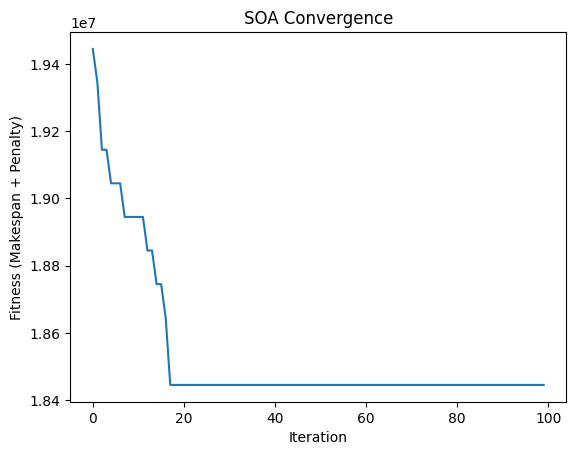


Best Solution:
1. Phân bổ tàu-bến (x):
[[0 0 0 1]
 [0 0 1 0]
 [1 1 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]]

2. Phân bổ cần cẩu (q):
[[0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0]
 [1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0]
 [1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1]
 [1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0]]

3. Phân bổ xe (y):
[[1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0
  1 0 1 1 0 1 1 0 1]
 [0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1
  0 0 0 1 0 1 1 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0
  1 0 0 1 0 0 0 0 1]
 [0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0
  1 0 0 1 0 0 1 1 0]
 [0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1
  1 0 0 1 0 1 1 1 1]
 [1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1
  1 

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# ==================== KHỞI TẠO TEST CASE ====================
np.random.seed(42)
V = 6  # Số tàu
B = 4  # Số bến
C = 23  # Số cần cẩu
Y = 45 # Số xe container
M = 99999  # Số lượng xe

# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
TA = np.array(TAi_float)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

# Khoảng cách từ bến đến bãi container (km)
D = np.array(np.array(Dij) / 1000)

# ==================== THUẬT TOÁN SOA ====================
class SeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        
    def initialize(self):
        # Khởi tạo quần thể ngẫu nhiên
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.random.randint(0, 2, size=(V, B)),  # Phân bổ tàu-bến
                'q': np.random.randint(0, 2, size=(V, C)),  # Phân bổ cần cẩu
                'y': np.random.randint(0, 2, size=(V, Y))   # Phân bổ xe
            }
            self.population.append(sol)
    
    def fitness(self, sol):
        """Tính hàm mục tiêu: tổng thời gian hoàn thành + penalty vi phạm ràng buộc"""
        makespan = 0
        penalty = 0
        
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += M
        
        # Ràng buộc 2: Mỗi cần cẩu chỉ phục vụ 1 tàu tại 1 thời điểm 
        for n in range(C):
            if sum(sol['q'][:, n]) > 1:
                penalty += M
        
        # Tính makespan (giả sử thời gian bắt đầu = thời gian đến)
        completion_times = TA + PT
        makespan = max(completion_times)
        
        return makespan + penalty
    
    def attack_prey(self, best_sol, current_sol):
        """Cập nhật vị trí theo hành vi tấn công con mồi"""
        new_sol = {}
        for key in ['x', 'q', 'y']:
            # Di chuyển về phía nghiệm tốt nhất
            new_sol[key] = np.where(
                np.random.rand(*current_sol[key].shape) < 0.5,
                best_sol[key],
                current_sol[key]
            )
        return new_sol
    
    def migrate(self, sol):
        """Mô phỏng hành vi di cư"""
        new_sol = {}
        for key in ['x', 'q', 'y']:
            # Thêm nhiễu ngẫu nhiên
            mutation_mask = np.random.rand(*sol[key].shape) < 0.1
            new_sol[key] = np.logical_xor(sol[key], mutation_mask).astype(int)
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        
        for iter in range(self.max_iter):
            for i in range(self.n_seagulls):
                # Tấn công con mồi
                new_sol = self.attack_prey(best_sol, self.population[i])
                
                # Di cư
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                
                # Chọn lọc
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            
            # Cập nhật nghiệm tốt nhất
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            
            fitness_history.append(self.fitness(best_sol))
            
            print(f"Iter {iter+1}, Best Fitness: {self.fitness(best_sol)}")
        
        # Visualize
        plt.plot(fitness_history)
        plt.title("SOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.show()
        
        return best_sol

# ==================== CHẠY THUẬT TOÁN ====================
soa = SeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = soa.optimize()

# ==================== HIỂN THỊ KẾT QUẢ ====================
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])
print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])
print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

Iter 1, Best Fitness: 1628788138.5614543
Iter 2, Best Fitness: 2365186527.1046586
Iter 3, Best Fitness: 3247692773.720534
Iter 4, Best Fitness: 4543254515.736415
Iter 5, Best Fitness: 5597181308.46105
Iter 6, Best Fitness: 7005594030.240289
Iter 7, Best Fitness: 8281543437.566623
Iter 8, Best Fitness: 9389847791.208307
Iter 9, Best Fitness: 10271887063.71116
Iter 10, Best Fitness: 11170082989.602667
Iter 11, Best Fitness: 12375136526.782253
Iter 12, Best Fitness: 13354512048.198828
Iter 13, Best Fitness: 14763577671.945353
Iter 14, Best Fitness: 16167892033.801037
Iter 15, Best Fitness: 17720910937.143856
Iter 16, Best Fitness: 19105550028.4248
Iter 17, Best Fitness: 20597316965.94563
Iter 18, Best Fitness: 22152871459.084515
Iter 19, Best Fitness: 23417495967.30703
Iter 20, Best Fitness: 24540921124.194443
Iter 21, Best Fitness: 25904661794.976505
Iter 22, Best Fitness: 27125815030.270607
Iter 23, Best Fitness: 28025593549.157276
Iter 24, Best Fitness: 29305750915.74538
Iter 25, Best 

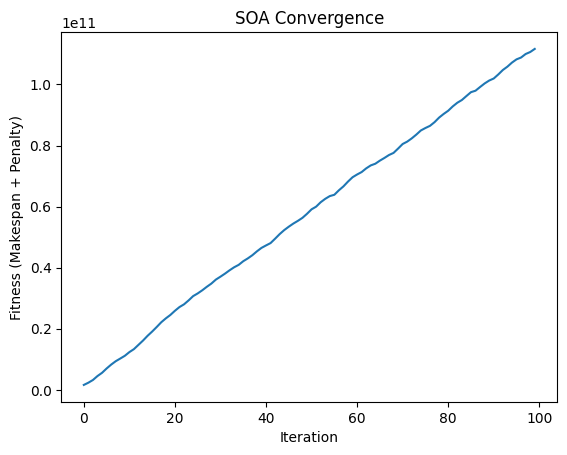


Best Solution:
1. Phân bổ tàu-bến (x):
[[1 1 1 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 1]
 [1 1 0 1]
 [1 1 0 1]]

2. Phân bổ cần cẩu (q):
[[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]

3. Phân bổ xe (y):
[[1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1
  0 1 1 0 1 0 1 1 0]
 [1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
  0 0 0 0 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0
  0 0 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1
  1 1 0 1 0 0 1 0 1]
 [0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1
  1 0 0 0 0 0 0 1 1]
 [1 1 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1
  1 

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# ==================== KHỞI TẠO TEST CASE ====================
np.random.seed(42)
V = 6  # Số tàu
B = 4  # Số bến
C = 23  # Số cần cẩu
Y = 45 # Số xe container
M = 99999  # Số lượng xe

TAi_float = [17444898.195785265, 17444926.143785268, 17444932.234308567, 17444951.114092693, 17444972.583434127, 17444983.25842754]
TF_float = [17444907.833333332, 17444952.0, 17444975.0, 17444982.0, 17444989.0, 17445012.0]
Dij = [[1831, 2290, 2574, 3031],
       [2499, 1934, 2139, 2566],
       [2499, 1934, 2139, 2566],
       [3114, 2535, 2054, 2922],
       [3157, 2861, 2273, 2015],
       [3157, 2861, 2273, 2015]]

# Thời gian đến (TA) và thời gian xử lý dự kiến (PT)
TA = np.array(TAi_float)  # Giờ
PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Giờ

# Khoảng cách từ bến đến bãi container (km)
D = np.array(np.array(Dij) / 1000)

# ==================== THUẬT TOÁN SOA ====================
class SeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        
    def initialize(self):
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.random.randint(0, 2, size=(V, B)),
                'q': np.zeros((V, C), dtype=int),  # Khởi tạo ma trận 0
                'y': np.random.randint(0, 2, size=(V, Y))
            }

            # Đảm bảo số cần cẩu nằm trong [VCmi[i], VCMi[i]]
            for i in range(V):
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)  # Số cần cẩu cho tàu i
                crane_indices = np.random.choice(C, size=num_cranes, replace=False)  # Chọn ngẫu nhiên cần cẩu
                sol['q'][i][crane_indices] = 1  # Gán giá trị 1 vào vị trí đã chọn

            self.population.append(sol)
    
    def fitness(self, sol):
        makespan = 0
        penalty = 0
        TW0 = 24  # Thời gian chờ tối đa 24h
        
        # Ràng buộc 1: Mỗi tàu chỉ vào 1 bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += M
        
        # Ràng buộc 2: Kiểm tra số cần cẩu tối thiểu/tối đa
        for i in range(V):
            total_cranes = sum(sol['q'][i])
            if total_cranes < VCmi[i] or total_cranes > VCMi[i]:
                penalty += M * abs(total_cranes - VCmi[i])
        
        # Ràng buộc 3: Thời gian chờ tối đa 24h
        # Giả sử TS_i là thời gian bắt đầu xếp/dỡ (tính từ TA_i)
        TS = np.zeros(V)  # Khởi tạo thời gian bắt đầu
        for i in range(V):
            berth = np.argmax(sol['x'][i])  # Bến được phân bổ
            # Thời gian bắt đầu = max(TA_i, thời gian bến rảnh)
            TS[i] = max(TA[i], self.get_berth_available_time(berth))
            # Tính thời gian chờ
            waiting_time = TS[i] - TA[i]
            if waiting_time > TW0:
                penalty += M * (waiting_time - TW0)  # Phạt nếu chờ > 24h
        
            # Cập nhật thời gian bận của bến
        for i in range(V):
            berth = np.argmax(sol['x'][i])
            self.berth_schedule[berth] = TS[i] + PT[i]  # Thời gian bến rảnh = TS + PT

        # Tính makespan (thời gian hoàn thành cuối cùng)
        completion_times = TS + PT
        makespan = max(completion_times)
        
        return makespan + penalty
    
    def get_berth_available_time(self, berth):
        """Tính thời gian bến `berth` sẵn sàng cho tàu tiếp theo"""
        # Giả sử lịch sử phân bổ được lưu trong self.berth_schedule
        if not hasattr(self, 'berth_schedule'):
            self.berth_schedule = {j: 0 for j in range(B)}  # Khởi tạo thời gian rảnh = 0

        return self.berth_schedule[berth]
    
    def attack_prey(self, best_sol, current_sol):
        new_sol = {}
        for key in ['x', 'q', 'y']:
            new_sol[key] = np.where(
                np.random.rand(*current_sol[key].shape) < 0.5,
                best_sol[key],
                current_sol[key]
            )
        
        # Kiểm tra và sửa nghiệm vi phạm TW0
        new_sol = self.repair_solution(new_sol)
        return new_sol
    
    def repair_solution(self, sol):
        """Sửa nghiệm vi phạm thời gian chờ"""
        TS = np.zeros(V)
        for i in range(V):
            berth = np.argmax(sol['x'][i])
            TS[i] = max(TA[i], self.get_berth_available_time(berth))
            
            # Nếu vi phạm TW0, điều chỉnh phân bổ bến
            if TS[i] - TA[i] > 24:
                # Tìm bến khác có thời gian chờ ≤ 24h
                for j in range(B):
                    new_TS = max(TA[i], self.get_berth_available_time(j))
                    if new_TS - TA[i] <= 24:
                        sol['x'][i] = np.zeros(B)
                        sol['x'][i][j] = 1
                        break
        return sol

    def migrate(self, sol):
        new_sol = {
            'x': np.logical_xor(sol['x'], np.random.rand(*sol['x'].shape) < 0.1).astype(int),
            'y': np.logical_xor(sol['y'], np.random.rand(*sol['y'].shape) < 0.1).astype(int),
            'q': sol['q'].copy()  # Giữ nguyên phân bổ cần cẩu để tránh vi phạm
        }
        return new_sol
    
    def optimize(self):
        self.initialize()
        best_sol = min(self.population, key=lambda x: self.fitness(x))
        fitness_history = []
        
        for iter in range(self.max_iter):
            for i in range(self.n_seagulls):
                # Tấn công con mồi
                new_sol = self.attack_prey(best_sol, self.population[i])
                
                # Di cư
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                
                # Chọn lọc
                if self.fitness(new_sol) < self.fitness(self.population[i]):
                    self.population[i] = new_sol
            
            # Cập nhật nghiệm tốt nhất
            current_best = min(self.population, key=lambda x: self.fitness(x))
            if self.fitness(current_best) < self.fitness(best_sol):
                best_sol = current_best
            
            fitness_history.append(self.fitness(best_sol))
            
            print(f"Iter {iter+1}, Best Fitness: {self.fitness(best_sol)}")
        
        # Visualize
        plt.plot(fitness_history)
        plt.title("SOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.show()
        
        return best_sol

# ==================== CHẠY THUẬT TOÁN ====================
soa = SeagullOptimization(n_seagulls=30, max_iter=100)
best_solution = soa.optimize()

# ==================== HIỂN THỊ KẾT QUẢ ====================
print("\nBest Solution:")
print("1. Phân bổ tàu-bến (x):")
print(best_solution['x'])
print("\n2. Phân bổ cần cẩu (q):")
print(best_solution['q'])
print("\n3. Phân bổ xe (y):")
print(best_solution['y'])

Iteration 1 - Best Fitness: 17445012.00
Iteration 2 - Best Fitness: 17445012.00
Iteration 3 - Best Fitness: 17445012.00
Iteration 4 - Best Fitness: 17445012.00
Iteration 5 - Best Fitness: 17445012.00
Iteration 6 - Best Fitness: 17445012.00
Iteration 7 - Best Fitness: 17445012.00
Iteration 8 - Best Fitness: 17445012.00
Iteration 9 - Best Fitness: 17445012.00
Iteration 10 - Best Fitness: 17445012.00
Iteration 11 - Best Fitness: 17445012.00
Iteration 12 - Best Fitness: 17445012.00
Iteration 13 - Best Fitness: 17445012.00
Iteration 14 - Best Fitness: 17445012.00
Iteration 15 - Best Fitness: 17445012.00
Iteration 16 - Best Fitness: 17445012.00
Iteration 17 - Best Fitness: 17445012.00
Iteration 18 - Best Fitness: 17445012.00
Iteration 19 - Best Fitness: 17445012.00
Iteration 20 - Best Fitness: 17445012.00
Iteration 21 - Best Fitness: 17445012.00
Iteration 22 - Best Fitness: 17445012.00
Iteration 23 - Best Fitness: 17445012.00
Iteration 24 - Best Fitness: 17445012.00
Iteration 25 - Best Fitne

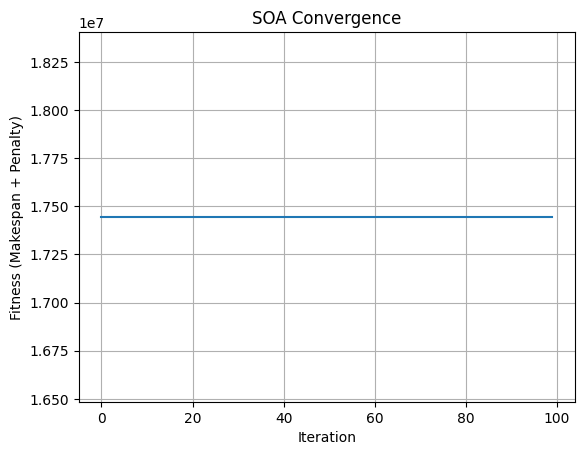


Phân bổ tàu-bến (x):
 [[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]]

Phân bổ cần cẩu (q):
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]

Phân bổ xe (y):
 [[0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0
  1 1 0 1 0 1 1 0 1]
 [1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0
  1 0 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0
  1 1 0 1 1 1 0 0 0]
 [1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1
  0 1 0 0 0 1 0 0 1]
 [0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0
  0 1 1 1 0 1 1 1 0]
 [1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0
  1 1 0 1 0 0 1 0 1]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==================== THÔNG SỐ BÀI TOÁN ====================
np.random.seed(42)
V = 6   # Số tàu
B = 4   # Số bến
C = 23  # Số cần cẩu
Y = 45  # Số xe container
M = 99999  # Hệ số phạt

# Thời gian đến và rời bến của tàu
TAi_float = [17444898.195785265, 17444926.143785268, 17444932.234308567,
             17444951.114092693, 17444972.583434127, 17444983.25842754]
TF_float = [17444907.833333332, 17444952.0, 17444975.0,
            17444982.0, 17444989.0, 17445012.0]

TA = np.array(TAi_float)
PT = np.array(TF_float) - TA

# Khoảng cách bến – bãi container
Dij = [[1831, 2290, 2574, 3031],
       [2499, 1934, 2139, 2566],
       [2499, 1934, 2139, 2566],
       [3114, 2535, 2054, 2922],
       [3157, 2861, 2273, 2015],
       [3157, 2861, 2273, 2015]]
D = np.array(Dij) / 1000

# Giới hạn số cần cẩu cho mỗi tàu
VCmi = [2, 2, 2, 2, 2, 2]
VCMi = [5, 5, 5, 5, 5, 5]

TB = [TAi_float[i] + 0.25 for i in range(len(TAi_float))]
TC = [TB[i] + TG0 for i in range(len(TB))] #Thời điểm tàu i đã vào cảng
TS = [TC[i] + float(10)/60 for i in range(len(TC))] 


# ==================== THUẬT TOÁN SOA ====================
class SeagullOptimization:
    def __init__(self, n_seagulls=30, max_iter=100):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter

    def initialize(self):
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B), dtype=int),
                'q': np.zeros((V, C), dtype=int),
                'y': np.random.randint(0, 2, size=(V, Y))
            }

            for i in range(V):
                sol['x'][i][np.random.randint(0, B)] = 1
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                crane_indices = np.random.choice(C, size=num_cranes, replace=False)
                sol['q'][i][crane_indices] = 1

            self.population.append(sol)

    def get_berth_available_time(self, berth):
        return self.berth_schedule.get(berth, 0)

    def fitness(self, sol):
        self.berth_schedule = {j: 0 for j in range(B)}
        TS = np.zeros(V)
        makespan = 0
        penalty = 0
        TW0 = 24

        for i in range(V):
            if np.sum(sol['x'][i]) != 1:
                penalty += M

            total_cranes = np.sum(sol['q'][i])
            if total_cranes < VCmi[i] or total_cranes > VCMi[i]:
                penalty += M * abs(total_cranes - VCmi[i])

            berth = np.argmax(sol['x'][i])
            TS[i] = max(TA[i], self.get_berth_available_time(berth))
            if TS[i] - TA[i] > TW0:
                penalty += M * (TS[i] - TA[i] - TW0)

            self.berth_schedule[berth] = TS[i] + PT[i]

        makespan = np.max(TS + PT)
        return makespan + penalty

    def attack_prey(self, best, current):
        new_sol = {}
        for key in ['x', 'q', 'y']:
            new_sol[key] = np.where(np.random.rand(*current[key].shape) < 0.5,
                                    best[key], current[key])
        return self.repair_solution(new_sol)

    def repair_solution(self, sol):
        TS = np.zeros(V)
        self.berth_schedule = {j: 0 for j in range(B)}
        for i in range(V):
            berth = np.argmax(sol['x'][i])
            TS[i] = max(TA[i], self.get_berth_available_time(berth))
            if TS[i] - TA[i] > 24:
                for j in range(B):
                    new_TS = max(TA[i], self.get_berth_available_time(j))
                    if new_TS - TA[i] <= 24:
                        sol['x'][i] = np.zeros(B)
                        sol['x'][i][j] = 1
                        break
            self.berth_schedule[berth] = TS[i] + PT[i]
        return sol

    def migrate(self, sol):
        new_sol = {
            'x': np.logical_xor(sol['x'], np.random.rand(*sol['x'].shape) < 0.1).astype(int),
            'y': np.logical_xor(sol['y'], np.random.rand(*sol['y'].shape) < 0.1).astype(int),
            'q': sol['q'].copy()
        }
        return new_sol

    def optimize(self):
        self.initialize()
        best = min(self.population, key=self.fitness)
        fitness_history = []

        for it in range(self.max_iter):
            new_population = []
            for sol in self.population:
                new_sol = self.attack_prey(best, sol)
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                if self.fitness(new_sol) < self.fitness(sol):
                    new_population.append(new_sol)
                else:
                    new_population.append(sol)
            self.population = new_population

            current_best = min(self.population, key=self.fitness)
            if self.fitness(current_best) < self.fitness(best):
                best = current_best

            fitness_history.append(self.fitness(best))
            print(f"Iteration {it+1} - Best Fitness: {self.fitness(best):.2f}")

        plt.plot(fitness_history)
        plt.title("SOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.grid()
        plt.show()
        return best


# ==================== CHẠY THUẬT TOÁN ====================
soa = SeagullOptimization()
best_solution = soa.optimize()

# ==================== KẾT QUẢ ====================
print("\nPhân bổ tàu-bến (x):\n", best_solution['x'])
print("\nPhân bổ cần cẩu (q):\n", best_solution['q'])
print("\nPhân bổ xe (y):\n", best_solution['y'])


Iter 1, Best Fitness: 25.0
Iter 2, Best Fitness: 25.0
Iter 3, Best Fitness: 25.0
Iter 4, Best Fitness: 25.0
Iter 5, Best Fitness: 25.0
Iter 6, Best Fitness: 25.0
Iter 7, Best Fitness: 25.0
Iter 8, Best Fitness: 25.0
Iter 9, Best Fitness: 25.0
Iter 10, Best Fitness: 25.0
Iter 11, Best Fitness: 25.0
Iter 12, Best Fitness: 25.0
Iter 13, Best Fitness: 25.0
Iter 14, Best Fitness: 25.0
Iter 15, Best Fitness: 25.0
Iter 16, Best Fitness: 25.0
Iter 17, Best Fitness: 25.0
Iter 18, Best Fitness: 25.0
Iter 19, Best Fitness: 25.0
Iter 20, Best Fitness: 25.0
Iter 21, Best Fitness: 25.0
Iter 22, Best Fitness: 25.0
Iter 23, Best Fitness: 25.0
Iter 24, Best Fitness: 25.0
Iter 25, Best Fitness: 25.0
Iter 26, Best Fitness: 25.0
Iter 27, Best Fitness: 25.0
Iter 28, Best Fitness: 25.0
Iter 29, Best Fitness: 25.0
Iter 30, Best Fitness: 25.0
Iter 31, Best Fitness: 25.0
Iter 32, Best Fitness: 25.0
Iter 33, Best Fitness: 25.0
Iter 34, Best Fitness: 25.0
Iter 35, Best Fitness: 25.0
Iter 36, Best Fitness: 25.0
I

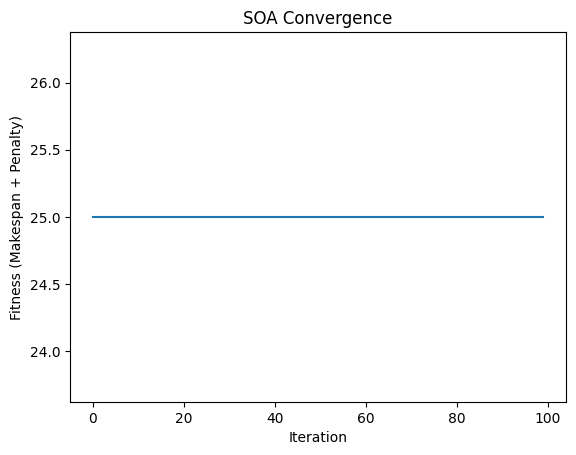


Phân bổ tàu-bến:
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]

Phân bổ cần cẩu:
[[1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1.]]
Tàu 0: Bến 2, Đến 0h, Bắt đầu 0h, Chờ 0h
Tàu 1: Bến 0, Đến 5h, Bắt đầu 5h, Chờ 0h


IndexError: index 4 is out of bounds for axis 0 with size 3

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

class SeagullOptimization:
    def __init__(self, n_seagulls=50, max_iter=200):
        self.n_seagulls = n_seagulls
        self.max_iter = max_iter
        self.M = 1000  # Hệ số phạt lớn

    def initialize(self, V, B, C, Y, VCmi, VCMi):
        """Khởi tạo quần thể ngẫu nhiên thỏa mãn ràng buộc"""
        self.population = []
        for _ in range(self.n_seagulls):
            sol = {
                'x': np.zeros((V, B)),  # Phân bổ tàu-bến
                'q': np.zeros((V, C)),  # Phân bổ cần cẩu
                'y': np.random.randint(0, 2, size=(V, Y))  # Phân bổ xe
            }
            
            # Khởi tạo phân bổ tàu-bến ngẫu nhiên
            for i in range(V):
                sol['x'][i, np.random.randint(B)] = 1
                
                # Khởi tạo số cần cẩu trong khoảng [VCmi[i], VCMi[i]]
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                crane_indices = np.random.choice(C, num_cranes, replace=False)
                sol['q'][i, crane_indices] = 1
            
            self.population.append(sol)
        return self

    def fitness(self, sol, TA, PT, VCmi, VCMi, TW0):
        """Tính độ thích nghi với các ràng buộc"""
        makespan = 0
        penalty = 0
        V, B = sol['x'].shape
        completion_times = np.zeros(V)
        berth_available = np.zeros(B)  # Thời gian bến rảnh
        
        # Kiểm tra ràng buộc phân bổ tàu-bến
        for i in range(V):
            if sum(sol['x'][i]) != 1:
                penalty += self.M
        
        # Kiểm tra ràng buộc cần cẩu
        for i in range(V):
            total_cranes = sum(sol['q'][i])
            if not (VCmi[i] <= total_cranes <= VCMi[i]):
                penalty += self.M * abs(total_cranes - VCmi[i])
        
        # Tính toán thời gian chờ và makespan
        for i in np.argsort(TA):  # Xử lý theo thứ tự tàu đến
            berth = np.argmax(sol['x'][i])
            start_time = max(TA[i], berth_available[berth])
            waiting_time = start_time - TA[i]
            
            # Phạt nếu thời gian chờ > TW0
            if waiting_time > TW0:
                penalty += self.M * (waiting_time - TW0)
            
            completion_times[i] = start_time + PT[i]
            berth_available[berth] = completion_times[i]
        
        makespan = max(completion_times)
        return makespan + penalty

    def attack_prey(self, best, current):
        """Toán tử tấn công con mồi"""
        new = deepcopy(current)
        for key in ['x', 'q', 'y']:
            mask = np.random.rand(*current[key].shape) < 0.5
            new[key][mask] = best[key][mask]
        return new

    def migrate(self, sol):
        """Toán tử di cư với đột biến"""
        new = deepcopy(sol)
        for key in ['x', 'y']:
            mutation = np.random.rand(*sol[key].shape) < 0.1
            new[key] = np.logical_xor(sol[key], mutation).astype(int)
        
        # Đột biến có kiểm soát cho cần cẩu
        for i in range(len(VCmi)):
            if np.random.rand() < 0.1:
                num_cranes = np.random.randint(VCmi[i], VCMi[i] + 1)
                new['q'][i] = 0
                crane_indices = np.random.choice(C, num_cranes, replace=False)
                new['q'][i, crane_indices] = 1
        return new

    def optimize(self, TA, PT, VCmi, VCMi, TW0):
        """Chạy thuật toán tối ưu"""
        V, B, C, Y = len(TA), len(VCmi), len(VCMi), 10  # Giả định Y=10 xe
        self.initialize(V, B, C, Y, VCmi, VCMi)
        
        best_sol = min(self.population, key=lambda x: self.fitness(x, TA, PT, VCmi, VCMi, TW0))
        fitness_hist = []
        
        for iter in range(self.max_iter):
            for i in range(self.n_seagulls):
                # Tạo nghiệm mới
                new_sol = self.attack_prey(best_sol, self.population[i])
                if np.random.rand() < 0.3:
                    new_sol = self.migrate(new_sol)
                
                # Chọn lọc
                if self.fitness(new_sol, TA, PT, VCmi, VCMi, TW0) < \
                   self.fitness(self.population[i], TA, PT, VCmi, VCMi, TW0):
                    self.population[i] = new_sol
            
            # Cập nhật nghiệm tốt nhất
            current_best = min(self.population, key=lambda x: self.fitness(x, TA, PT, VCmi, VCMi, TW0))
            if self.fitness(current_best, TA, PT, VCmi, VCMi, TW0) < \
               self.fitness(best_sol, TA, PT, VCmi, VCMi, TW0):
                best_sol = current_best
            
            fitness_hist.append(self.fitness(best_sol, TA, PT, VCmi, VCMi, TW0))
            print(f"Iter {iter+1}, Best Fitness: {fitness_hist[-1]}")
        
        # Visualize
        plt.plot(fitness_hist)
        plt.title("SOA Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness (Makespan + Penalty)")
        plt.show()
        
        return best_sol

# ==================== TEST CASE ====================
if __name__ == "__main__":
    # Dữ liệu đầu vào
    TA = np.array(TAi_float)  # Thời gian đến
    PT = np.array(np.array(TF_float) - np.array(TAi_float))    # Thời gian xử lý
    VCmi = np.array([1, 1, 2, 2, 1])    # Cần cẩu tối thiểu mỗi tàu
    VCMi = np.array([3, 3, 4, 4, 3])    # Cần cẩu tối đa mỗi tàu
    TW0 = 24  # Thời gian chờ tối đa (giờ)
    B = 3     # Số bến
    C = 5     # Số cần cẩu

    # Chạy thuật toán
    soa = SeagullOptimization(n_seagulls=30, max_iter=100)
    best = soa.optimize(TA, PT, VCmi, VCMi, TW0)

    # Hiển thị kết quả
    print("\nPhân bổ tàu-bến:")
    print(best['x'])
    print("\nPhân bổ cần cẩu:")
    print(best['q'])
    
    # Tính toán thời gian thực tế
    berth_available = np.zeros(B)
    for i in np.argsort(TA):
        berth = np.argmax(best['x'][i])
        start = max(TA[i], berth_available[berth])
        wait = start - TA[i]
        print(f"Tàu {i}: Bến {berth}, Đến {TA[i]}h, Bắt đầu {start}h, Chờ {wait}h")
        berth_available[berth] = start + PT[i]
    
    print(f"\nMakespan: {max(berth_available)} giờ")